In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

class CVCircuit:
    def __init__(self, num_modes, quadratures_ordering='qpqp', mean_vector = None, cov_matrix = None, cluster_state = None):
        """
        Initializes a continuous-variable quantum circuit with the specified number of modes.
        
        Parameters:
        num_modes (int): The number of modes in the circuit.
        """
        if not isinstance(num_modes, int) or num_modes <= 0:
            raise ValueError("num_modes must be a positive integer.")
        
        if quadratures_ordering !='qpqp' and quadratures_ordering !='qqpp':
            raise ValueError("quadratures_ordering must be either 'qpqp' or 'qqpp'.")    
        
        self.quadratures_ordering = quadratures_ordering
        self.num_modes = num_modes
        self.num_quadratures = 2 * num_modes

        if mean_vector is None:
            self.mean_vector = np.zeros(self.num_quadratures)
        else:
            self.mean_vector = mean_vector

        if cov_matrix is None:
            self.cov_matrix = np.identity(self.num_quadratures)
        else:
            self.cov_matrix = cov_matrix
        
        if self.quadratures_ordering == 'qpqp':
            self.J = np.kron(np.eye(self.num_modes), np.array([[0, 1], [-1, 0]]))
        else:
            self.J = np.kron(np.array([[0, 1], [-1, 0]]), np.eye(self.num_modes))
        
        if cluster_state is not None:
            self.mean_vector = np.zeros(self.num_quadratures)
            self.cov_matrix = np.identity(self.num_quadratures)
            self.A = cluster_state[0]
            self.epsilon_squeezing = cluster_state[1] #epsilon = exp(-2r), where r is the parameter to define the squeezing in the corresponding method. The squeezing in q quadrature is exp(r) and the one in p quadrature is exp(-r). If sqeezing is zero (r=0) epsilon_squeezing = 1
            self.squeezing()
            self.cz_gate()
        else:
            self.A = None
            self.epsilon_squeezing = None
            
        print(f"'{self.quadratures_ordering}' ordering. Specify different ordering through the parameter 'quadratures_ordering'. Default is 'qpqp'")
          
    def __repr__(self):
        """
        Provides a string representation of the CVCircuit instance.
        """
        return (f"CVCircuit(num_modes={self.num_modes}, "
                f"cov_matrix={self.cov_matrix}, mean_vector={self.mean_vector})")

    def change_quad_ordering(self):
        """
        Changes the ordering of the quadratures between 'qpqp' and 'qqpp'.
        """
        
        # Permutation to change ordering
        P = np.eye(2 * self.num_modes)
        permutation = np.empty(2 * self.num_modes, dtype=int)
        permutation[:self.num_modes] = np.arange(0, 2 * self.num_modes, 2)
        permutation[self.num_modes:] = np.arange(1, 2 * self.num_modes, 2)
        P = P[permutation]

        if self.quadratures_ordering == 'qpqp':
            self.mean_vector = P @ self.mean_vector
            self.cov_matrix = P @ self.cov_matrix @ P.T
            self.J = P @ self.J @ P.T
            new_ordering = 'qqpp'

        elif self.quadratures_ordering == 'qqpp':
            self.mean_vector = P.T @ self.mean_vector
            self.cov_matrix = P.T @ self.cov_matrix @ P
            self.J = P.T @ self.J @ P
            new_ordering = 'qpqp'

        self.quadratures_ordering = new_ordering
        print(f"Changed quadratures ordering to '{self.quadratures_ordering}'")

#####GATES
    def displacement(self, alpha, mode=0): #(checked)
        """
        Applies a displacement gate to the specified mode.
        
        Parameters:
        alpha (complex): The displacement parameter.
        mode (int): The mode to apply the displacement to.
        """
        if mode < 0 or mode >= self.num_modes:
            raise ValueError("Invalid mode index.")
        
        if self.quadratures_ordering == 'qpqp':
            self.mean_vector[2*mode] += np.sqrt(2)*np.real(alpha)
            self.mean_vector[2*mode + 1] += np.sqrt(2)*np.imag(alpha)
        else: 
            self.change_quad_ordering() 
            self.mean_vector[2*mode] += np.sqrt(2)*np.real(alpha)
            self.mean_vector[2*mode + 1] += np.sqrt(2)*np.imag(alpha)
            self.change_quad_ordering()
        
    def rotation(self, phi, mode=0): #(checked)
        """
        Applies a rotation gate to the specified mode.
        
        Parameters:
        phi (float): The rotation angle.
        mode (int): The mode to apply the rotation to.
        """
        if mode < 0 or mode >= self.num_modes:
            raise ValueError("Invalid mode index.")
        
        R = np.identity(self.num_quadratures)
        R[2*mode:2*mode+2, 2*mode:2*mode+2] = [[np.cos(phi), np.sin(phi)], [-np.sin(phi), np.cos(phi)]]
        
        if self.quadratures_ordering =='qpqp':
            self.cov_matrix = R @ self.cov_matrix @ R.T
            self.mean_vector = R @ self.mean_vector
        else:
            self.change_quad_ordering()
            self.cov_matrix = R @ self.cov_matrix @ R.T
            self.mean_vector = R @ self.mean_vector
            self.change_quad_ordering()
        
    def squeezing(self, r=0, mode=0): #(checked)
        """
        Applies a squeezing gate to the specified mode.
        
        Parameters:
        r (float): The squeezing parameter.
        mode (int): The mode to apply the squeezing to.
        """
        epsilon = self.epsilon_squeezing

        if epsilon is not None:
            if epsilon <= 0: 
                raise ValueError("Invalid epsilon-squeezing value.")

            S = np.zeros(self.num_quadratures)
            S[0:len(S):2] = 1/np.sqrt(epsilon) #because epsilon = exp(-2r) so exp(r) = 1/sqrt(epsilon) and exp(-r) = sqrt(epsilon)
            S[1:len(S):2] = np.sqrt(epsilon)
            S = np.diag(S)

        else:
            if mode < 0 or mode >= self.num_modes:
                raise ValueError("Invalid mode index.")
            
            S = np.identity(self.num_quadratures)
            S[2*mode, 2*mode] = np.exp(r)
            S[2*mode + 1, 2*mode + 1] = np.exp(-r)
        
        if self.quadratures_ordering =='qpqp':
            self.cov_matrix = S @ self.cov_matrix @ S.T
            self.mean_vector = S @ self.mean_vector
        else:
            self.change_quad_ordering()
            self.cov_matrix = S @ self.cov_matrix @ S.T
            self.mean_vector = S @ self.mean_vector
            self.change_quad_ordering()
     
    def beamsplitter(self, theta, mode1=None, mode2=None, A=None): #(checked)
        """
        Apply a beamsplitter operation.

        Parameters:
        - theta (float, optional): The transmission coefficient .
        - mode1 (int, optional): The first mode index.
        - mode2 (int, optional): The second mode index.
        - A (numpy.ndarray, optional): Symmetric matrix defining the strength of beamsplitter operations between modes.

        Raises:
        - ValueError: If the matrix A is not symmetric or the mode indices are invalid.
        """
        
        if A is not None:
            if not isinstance(A, np.ndarray):
                raise ValueError("Matrix A must be a numpy array.")
            if A.shape != (self.num_modes, self.num_modes):
                raise ValueError(f"Matrix A must be of shape ({self.num_modes},{self.num_modes}).")
            if not np.allclose(A, A.T):
                raise ValueError("Matrix A must be symmetric.")
            for i in range(self.num_modes):
                for j in range(i+1, self.num_modes):
                    if A[i, j] != 0:
                        t = A[i, j]
                        self._apply_beamsplitter(t, i, j)
        else:
            if mode1 is None or mode2 is None:
                raise ValueError("mode1 and mode2 must be specified if A is not provided.")
            if mode1 < 0 or mode1 >= self.num_modes or mode2 < 0 or mode2 >= self.num_modes:
                raise ValueError("Invalid mode index.")
            
            self._apply_beamsplitter(theta, mode1, mode2)
            
    def _apply_beamsplitter(self, theta, mode1, mode2): #(checked)
        BS_building_block = np.kron([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]],np.identity(2))
        BS_first_modes = np.identity(self.num_quadratures)
        BS_first_modes[0:4,0:4] = BS_building_block
        BS = self._permutation_matrix_shift_modes(self, mode1, mode2).T @ BS_first_modes @ self._permutation_matrix_shift_modes(self, mode1, mode2)
        
        if self.quadratures_ordering == 'qpqp':
            self.cov_matrix = BS @ self.cov_matrix @ BS.T
            self.mean_vector = BS @ self.mean_vector
        else:
            self.change_quad_ordering()
            self.cov_matrix = BS @ self.cov_matrix @ BS.T
            self.mean_vector = BS @ self.mean_vector
            self.change_quad_ordering()

    def cz_gate(self, phase=0, mode1=None, mode2=None): #(checked)
        """
        Apply a CZ gate operation.

        Parameters:
        - phase (float, optional): The intensity of the CZ gate.
        - mode1 (int, optional): The first mode index.
        - mode2 (int, optional): The second mode index.
        - A (numpy.ndarray, optional): Symmetric matrix defining the intensity of CZ gate operations between modes.

        Raises:
        - ValueError: If the matrix A is not symmetric or the mode indices are invalid.
        """
        A = self.A
        if A is not None:
            if not isinstance(A, np.ndarray):
                raise ValueError("Matrix A must be a numpy array.")
            if A.shape != (self.num_modes, self.num_modes):
                raise ValueError(f"Matrix A must be of shape ({self.num_modes}, {self.num_modes}).")
            if not np.allclose(A, A.T):
                raise ValueError("Matrix A must be symmetric.")
            for i in range(self.num_modes):
                for j in range(i+1, self.num_modes):
                    if A[i, j] != 0:
                        intensity = A[i, j]
                        self._apply_cz_gate(intensity, i, j)
        else:
            if mode1 is None or mode2 is None:
                raise ValueError("mode1 and mode2 must be specified if A is not provided.")
            if mode1 < 0 or mode1 >= self.num_modes or mode2 < 0 or mode2 >= self.num_modes:
                raise ValueError("Invalid mode index.")
            self._apply_cz_gate(phase, mode1, mode2)
            
    def _apply_cz_gate(self, phase, mode1, mode2): #(checked)
        CZ_first_modes = np.identity(self.num_quadratures)
        CZ_first_modes[3,0] = CZ_first_modes[1,2] = phase
        CZ = self._permutation_matrix_shift_modes(mode1, mode2).T @ CZ_first_modes @ self._permutation_matrix_shift_modes(mode1, mode2)
        
        if self.quadratures_ordering == 'qpqp':
            self.cov_matrix = CZ @ self.cov_matrix @ CZ.T
            self.mean_vector = CZ @ self.mean_vector
        else:
            self.change_quad_ordering()
            self.cov_matrix = CZ @ self.cov_matrix @ CZ.T
            self.mean_vector = CZ @ self.mean_vector
            self.change_quad_ordering()
        
    def _permutation_matrix_shift_modes(self, k, l): #(checked)
        """
        Create a permutation matrix to shift modes k and l to the first two modes.
        
        Parameters:
        n (int): Number of modes.
        k (int): Index of the first mode to shift (zero-indexed).
        l (int): Index of the second mode to shift (zero-indexed).
        
        Returns:
        np.ndarray: The permutation matrix of size (2n x 2n).
        """
        
        # Identity matrix of size 2n
        P = np.identity(self.num_quadratures)
        
        # Swap mode k to the first mode position
        if k != 0:
            P[[0, 2 * k]] = P[[2 * k, 0]]
            P[[1, 2 * k + 1]] = P[[2 * k + 1, 1]]
        
        # Swap mode l to the second mode position
        if l != 1:
            P[[2, 2 * l]] = P[[2 * l, 2]]
            P[[3, 2 * l + 1]] = P[[2 * l + 1, 3]]
        
        return P
    
    def random_gaussian(self,max_displacement = 0, max_squeezing = 2, max_rotation = 2*np.pi,  max_bs = 1): #(checked)
        """
        Applies a series of random Gaussian operations to create a random Gaussian state.
        
        Parameters:
        no_displacement (bool): If True, no displacement will be applied.
        """
        for mode in range(self.num_modes):
            
            alpha = np.random.uniform(-max_displacement, max_displacement) + 1j * np.random.uniform(-max_displacement, max_displacement)
            self.displacement(alpha, mode)
            
            r = np.random.uniform(0, max_squeezing)
            self.squeezing(r, mode)
            
            phi = np.random.uniform(0, max_rotation)
            self.rotation(phi, mode)
 
        for mode1 in range(self.num_modes):
            for mode2 in range(mode1 + 1, self.num_modes):
                theta = np.random.uniform(0, max_bs)
                self.beamsplitter(theta, mode1, mode2)
                
#####CHECKS 
    def is_quantum(self): #(checked)
        """
        Checks if the current state satisfies the uncertenty roberson-shroedinger principle.
        
        Returns:
        bool: True if the state satisfies conditions, False otherwise.
        """
        symplectic_eigenvalues = self.get_symp_eigs(self.cov_matrix)
        
        if np.all(symplectic_eigenvalues) >= 1:
            return True
        return False
    
    def is_gaussian(self): #(checked)
        """
        Checks if the current state is a gaussian quantum state.
        
        Returns:
        bool: True if the state satisfies conditions, False otherwise.
        """
        symplectic_eigenvalues = self.get_symp_eigs(self.cov_matrix)
        
        if np.all(symplectic_eigenvalues) >= 1 and np.all(symplectic_eigenvalues) < (1. + 1e-2):
            return True
        return False
        
#####STATE OPERATIONS
    def get_symp_eigs(self, matrix_to_diag = None, symp_matrix = None): #(checked)

        if matrix_to_diag is not None:
            matrix = matrix_to_diag
        else:
            matrix = self.cov_matrix

        if symp_matrix is not None:
            J = symp_matrix
        else:
            J = self.J

        if not J.shape == matrix.shape:
            raise ValueError("The sympletic matrix and the matrix you want to diagonalize do not have the same shape!")
        
        symplectic_eigenvalues = np.linalg.eigvals(J @ matrix)
        symplectic_eigenvalues = np.imag(symplectic_eigenvalues)
        symplectic_eigenvalues = symplectic_eigenvalues[symplectic_eigenvalues > 0]
        symplectic_eigenvalues = np.sort(symplectic_eigenvalues)[::-1]
        #print(f" symp eigns {symplectic_eigenvalues}")
        
        return symplectic_eigenvalues
    
    def get_symp_eigs_after_trace_out(self, modes_to_trace_out): #(check if it makes sense in general or only for cluster states which are the ones obtained by cz gates)
    
        P_full = np.identity(self.num_modes)
        for mode in modes_to_trace_out:
            P_full[mode, mode] = 0

        P = P_full[~np.all(P_full == 0, axis=1)]

        zeros_block = np.zeros_like(P)
        tilde_P = np.block([
            [P, zeros_block],
            [zeros_block, P]
        ])

        if self.quadratures_ordering == 'qpqp':
            self.change_quad_ordering()
            cov_matrix = self.cov_matrix
            J = self.J
            self.change_quad_ordering()
        else:
            cov_matrix = self.cov_matrix
            J = self.J

       
        reduced_J = tilde_P @ J @ tilde_P.T
        reduced_cov_matrix = tilde_P @ cov_matrix @ tilde_P.T
        #print(f"reduced cov mat {reduced_cov_matrix}")
        #print(f"reduced J {reduced_J}")
        #print(f"reduced cov * J {reduced_cov_matrix @ reduced_J}")
        
        return self.get_symp_eigs(reduced_cov_matrix,reduced_J)

    def get_eigs_graph_partition(self, modes_to_trace_out):

        P_full = np.identity(self.num_modes)
        for mode in modes_to_trace_out:
            P_full[mode, mode] = 0

        P = P_full[~np.all(P_full == 0, axis=1)] 
        
        A_reduced = P @ self.A @ P.T
        A_squared_reduced = P @ self.A @ self.A @ P.T

        eigvals = np.linalg.eigvalsh(A_squared_reduced - A_reduced @ A_reduced)
        eigvals = np.sort(eigvals)[::-1]

        return eigvals
    
    def get_analytical_covmat_A(self): #(checked)
        """Formula from paper Graphical Calculus for Gaussian States that express the cov matrix for cluster states as a function of squeezing and CZ topology

        Raises:
            ValueError: _description_
        """
        
        cov_mat_anal_A = np.identity(self.num_quadratures)
        cov_mat_anal_A[0:self.num_modes, self.num_modes:2*self.num_modes] = cov_mat_anal_A[self.num_modes:2*self.num_modes, 0:self.num_modes] = self.A
        cov_mat_anal_A[self.num_modes:2*self.num_modes, self.num_modes:2*self.num_modes] = self.epsilon_squeezing*self.epsilon_squeezing*np.identity(self.num_modes)+self.A @ self.A
        cov_mat_anal_A = (1/self.epsilon_squeezing)*cov_mat_anal_A
        
        if self.quadratures_ordering == 'qpqp':
            self.change_quad_ordering()
            perm_cov_matrix = self.cov_matrix
            self.change_quad_ordering()
        else:
            perm_cov_matrix = self.cov_matrix

        return np.allclose(cov_mat_anal_A, perm_cov_matrix, atol=1e-1)
    
    def get_purity_gaussian(self, modes=None): #(checked)
        """
        Calculates the purity of the quantum state for specified modes or the entire system.
        
        Parameters:
        modes (list, optional): The list of modes to consider. If None, the entire system is considered.
        
        Returns:
        float: The purity of the state.
        """
        
        control = self.is_gaussian()
        if not control:
            raise ValueError("This method is valid only for gaussian state but this state is not gaussian.")
        
        if modes is None:
            cov_matrix = self.cov_matrix
        else:
            indices = []
            for mode in modes:
                indices.extend([2*mode, 2*mode + 1])
            cov_matrix = self.cov_matrix[np.ix_(indices, indices)]
            
        purity = 1 / np.sqrt(np.linalg.det(cov_matrix)) 
        return purity
            
    def get_entang_entropy(self): #(probably correct but numerical errors for pure gaussian states for 0log(0))
        """
        Computes the entanglement entropy of the system.
        
        Returns:
        float: The full entanglement entropy.
        """
        symplectic_eigenvalues = self.get_symp_eigs(self.cov_matrix)
        print(symplectic_eigenvalues)
        
        entropy = 0
        for nu in symplectic_eigenvalues:
            print(f"first term: {(nu + 1) / 2 * np.log((nu + 1) / 2)}")
            print(f"second term: {- (nu - 1) / 2 * np.log((nu - 1) / 2)}")
            entropy += (nu + 1) / 2 * np.log((nu + 1) / 2) - (nu - 1) / 2 * np.log((nu - 1) / 2)
            print(f"entropy until now {entropy}")
            
        return entropy

    def get_renyi2(self, modes=None): #(checked)
        """
        Computes the renyi entanglement entropy for a subset of modes or full sistem if modes = None.
        
        Parameters:
        modes (list): The list of modes to consider for the reduced system.
        
        Returns:
        float: renyi entropy.
        """
        control = self.is_gaussian()
        if not control:
            raise ValueError("This method is valid only for gaussian state but this state is not gaussian.")
        
        if modes is None:
            cov_matrix = self.cov_matrix
        else:
            indices = []
            for mode in modes:
                indices.extend([2*mode, 2*mode + 1])
            cov_matrix = self.cov_matrix[np.ix_(indices, indices)]
            
        renyi2_entropy = (1/2)*np.log(np.linalg.det(cov_matrix))
        
        return renyi2_entropy
    
    
#####PLOT
    def plot_wigner_function(self): #(checked)
        """
        Plots the Wigner function for a single-mode system.
        """
        if self.num_modes != 1:
            raise ValueError("Wigner function plot can only be called for a single mode system.")
        
        cov_matrix = self.cov_matrix[:2, :2]
        mean_vector = self.mean_vector[:2]
        
        x = np.linspace(-5, 5, 100)
        p = np.linspace(-5, 5, 100)
        X, P = np.meshgrid(x, p)
        pos = np.empty(X.shape + (2,))
        pos[:, :, 0] = X
        pos[:, :, 1] = P
        
        inv_cov_matrix = np.linalg.inv(cov_matrix)
        diff = pos - mean_vector
        exponent = -0.5 * np.einsum('...k,kl,...l->...', diff, inv_cov_matrix, diff)
        W = np.exp(exponent) / (np.pi * np.sqrt(np.linalg.det(cov_matrix)))
        
        plt.contourf(X, P, W, levels=100, cmap='RdYlBu')
        plt.xlabel('q')
        plt.ylabel('p')
        plt.title('Wigner Function')
        plt.colorbar()
        plt.show()



In [2]:
N = 10
eps_squeezing = 1
modes_trace_out = [0,1]


[[0. 1. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


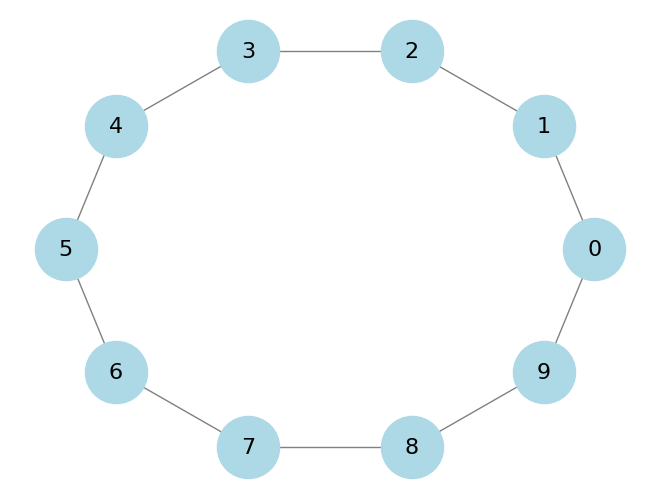

In [3]:
# A = np.random.rand(N,N)
# A = np.triu(A,1) + np.triu(A, 1).T 
G = nx.watts_strogatz_graph(N, 2, 0, seed=None)
A = nx.to_numpy_array(G)
print(A)
eigvals_A = np.linalg.eigvalsh(A)

# Assign random weights to the edges 
#weights = {edge: weight for edge, weight in zip(G.edges(), np.random.rand(N))}
#nx.set_edge_attributes(G, weights, 'weight')

# Draw the circular graph
pos = nx.circular_layout(G)  # Positions nodes in a circle
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=16, edge_color='gray')

# Draw edge labels to show weights
edge_labels = nx.get_edge_attributes(G, 'weight')
edge_labels = {k: f'{v:.2f}' for k, v in edge_labels.items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the plot
plt.show()


In [4]:
circuit = CVCircuit(N,cluster_state=(A,eps_squeezing))
if circuit.num_modes ==1:
    circuit.plot_wigner_function()


'qpqp' ordering. Specify different ordering through the parameter 'quadratures_ordering'. Default is 'qpqp'


In [5]:
print(circuit.is_gaussian())
print(circuit.get_purity_gaussian())
print(circuit.get_analytical_covmat_A())
print(circuit.get_renyi2(modes_trace_out))



True
0.9999999999999998
Changed quadratures ordering to 'qqpp'
Changed quadratures ordering to 'qpqp'
True
0.6931471805599454


In [6]:
nus_squared = circuit.get_eigs_graph_partition(modes_trace_out)
sigmas = circuit.get_symp_eigs_after_trace_out(modes_trace_out)
print(np.all(np.isreal(nus_squared)))
print(nus_squared)
print(sigmas)
print(eigvals_A)


Changed quadratures ordering to 'qqpp'
Changed quadratures ordering to 'qpqp'
True
[1. 1. 0. 0. 0. 0. 0. 0.]
[1.41421356 1.41421356 1.         1.         1.         1.
 1.         1.        ]
[-2.         -1.61803399 -1.61803399 -0.61803399 -0.61803399  0.61803399
  0.61803399  1.61803399  1.61803399  2.        ]


In [7]:
check_sigmas = []
for nu in nus_squared:
    check_sigmas.append(np.sqrt(1+(nu/(eps_squeezing*eps_squeezing))))
np.allclose(sigmas[:],check_sigmas[:], atol=1e-1)



True

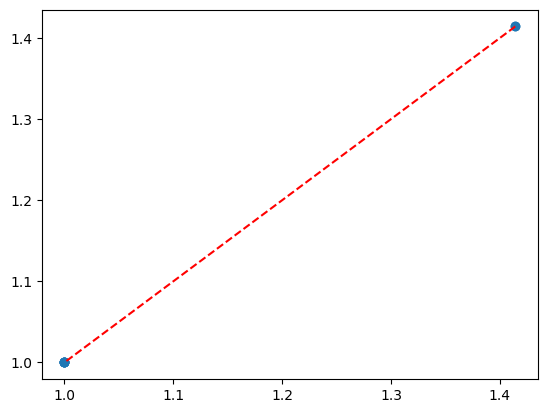

8


In [8]:
x = [i for i in range(len(sigmas))]
plt.plot(sigmas,check_sigmas,'o')
plt.plot(sigmas, sigmas, color='red', linestyle='--')
plt.show()
print(len(check_sigmas))

In [9]:
N = 10
eps_squeezing = 1
modes_trace_out = [0,1]

iterations = 200
info_array = []
for ii in range(iterations):
    info_dict = {}
    A = np.random.rand(N,N)
    A = np.triu(A,1) + np.triu(A, 1).T
    info_dict['A'] = A
    circuit = CVCircuit(N,cluster_state=(A,eps_squeezing))
    info_dict['check_anal_A'] = circuit.get_analytical_covmat_A()
    nus_squared = circuit.get_eigs_graph_partition(modes_trace_out)
    nus_squared = np.sort(nus_squared)[::-1]
    sigmas = circuit.get_symp_eigs_after_trace_out(modes_trace_out)
    sigmas = np.sort(sigmas)[::-1]
    info_dict['check_nus2_real'] = np.all(np.isreal(nus_squared))
    check_sigmas = []
    for nu in nus_squared:
        check_sigmas.append(np.sqrt(1+(nu/(eps_squeezing*eps_squeezing))))
    info_dict['check_sigmas_vs_nus2'] = np.allclose(sigmas,check_sigmas, atol=1e-1)
    info_dict['sigmas'] = sigmas
    info_dict['nus2'] = nus_squared
    info_array.append(info_dict)
    


'qpqp' ordering. Specify different ordering through the parameter 'quadratures_ordering'. Default is 'qpqp'
Changed quadratures ordering to 'qqpp'
Changed quadratures ordering to 'qpqp'
Changed quadratures ordering to 'qqpp'
Changed quadratures ordering to 'qpqp'
'qpqp' ordering. Specify different ordering through the parameter 'quadratures_ordering'. Default is 'qpqp'
Changed quadratures ordering to 'qqpp'
Changed quadratures ordering to 'qpqp'
Changed quadratures ordering to 'qqpp'
Changed quadratures ordering to 'qpqp'
'qpqp' ordering. Specify different ordering through the parameter 'quadratures_ordering'. Default is 'qpqp'
Changed quadratures ordering to 'qqpp'
Changed quadratures ordering to 'qpqp'
Changed quadratures ordering to 'qqpp'
Changed quadratures ordering to 'qpqp'
'qpqp' ordering. Specify different ordering through the parameter 'quadratures_ordering'. Default is 'qpqp'
Changed quadratures ordering to 'qqpp'
Changed quadratures ordering to 'qpqp'
Changed quadratures or

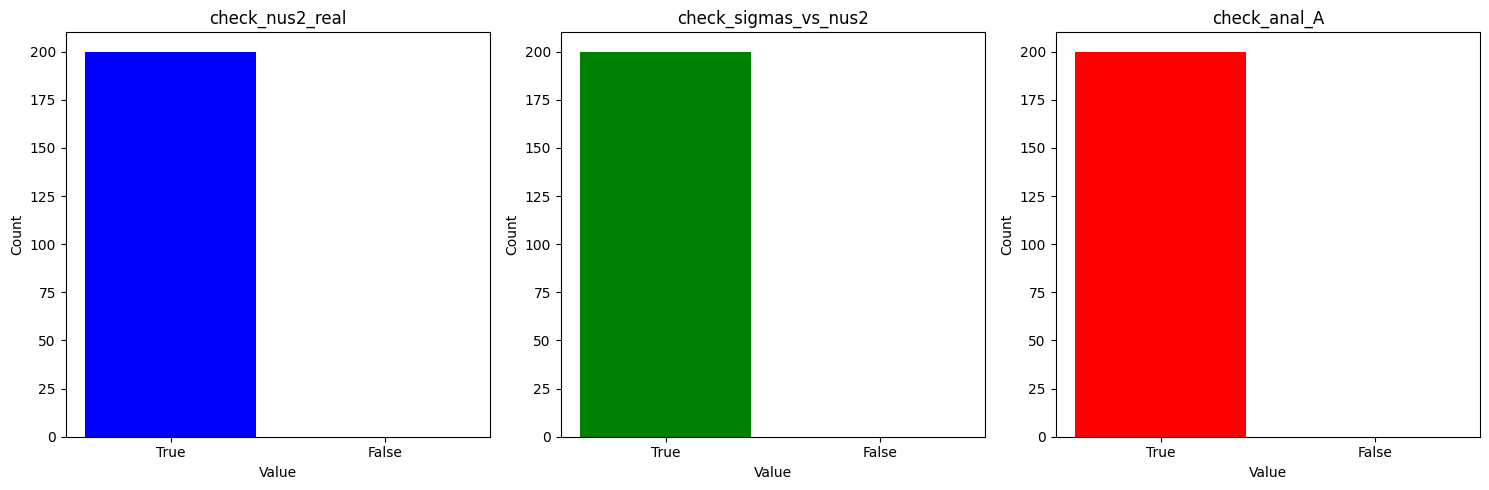

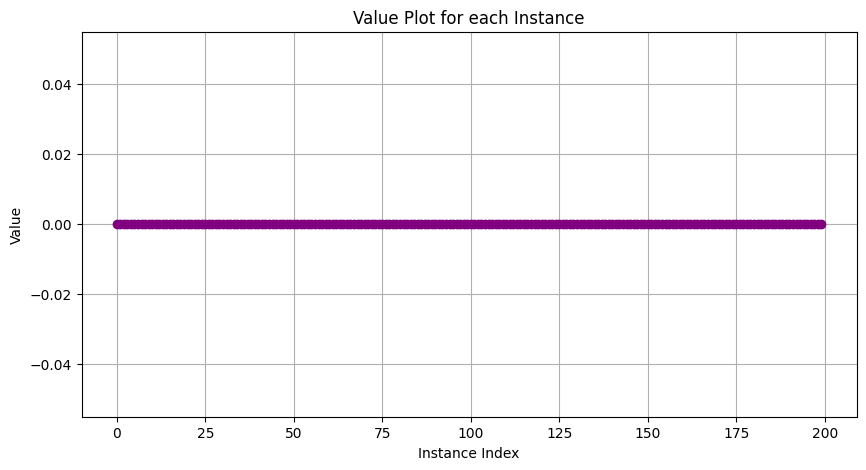

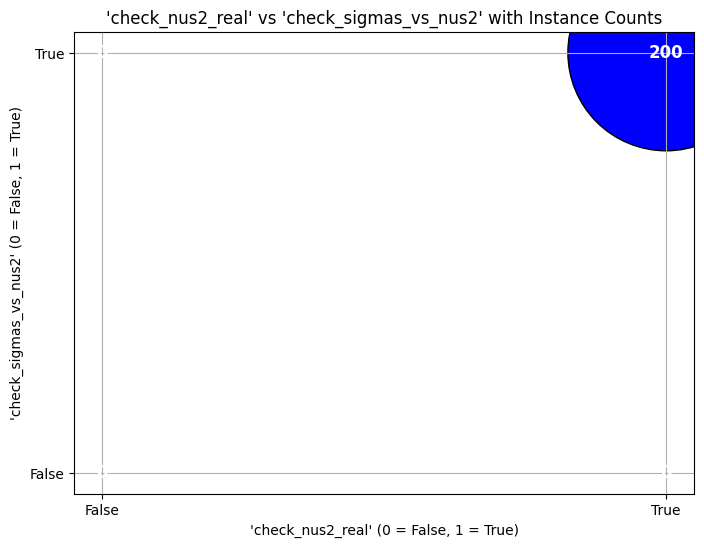

In [29]:
# Initialize counters for the first figure
nus2_real_counts = {'True': 0, 'False': 0}
sigmas_vs_nus2_counts = {'True': 0, 'False': 0}
anal_A_counts = {'True': 0, 'False': 0}

# Initialize values for the second figure
plot_values = []

# Iterate over each instance in the list
for instance in info_array:
    # Update the counts for each key
    nus2_real_counts[str(instance['check_nus2_real'])] += 1
    sigmas_vs_nus2_counts[str(instance['check_sigmas_vs_nus2'])] += 1
    anal_A_counts[str(instance['check_anal_A'])] += 1
    
    # Calculate the value for the second plot
    if instance['check_nus2_real'] and not instance['check_sigmas_vs_nus2']:
        plot_values.append(1)
    elif not instance['check_nus2_real'] and instance['check_sigmas_vs_nus2']:
        plot_values.append(-1)
    elif instance['check_nus2_real'] and instance['check_sigmas_vs_nus2']:
        plot_values.append(0)
    elif not instance['check_nus2_real'] and not instance['check_sigmas_vs_nus2']:
        plot_values.append(-2)

# Create the first figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Histogram for 'check_nus2_real'
axs[0].bar(nus2_real_counts.keys(), nus2_real_counts.values(), color='blue')
axs[0].set_title('check_nus2_real')
axs[0].set_ylabel('Count')
axs[0].set_xlabel('Value')

# Histogram for 'check_sigmas_vs_nus2'
axs[1].bar(sigmas_vs_nus2_counts.keys(), sigmas_vs_nus2_counts.values(), color='green')
axs[1].set_title('check_sigmas_vs_nus2')
axs[1].set_ylabel('Count')
axs[1].set_xlabel('Value')

# Histogram for 'check_anal_A'
axs[2].bar(anal_A_counts.keys(), anal_A_counts.values(), color='red')
axs[2].set_title('check_anal_A')
axs[2].set_ylabel('Count')
axs[2].set_xlabel('Value')

plt.tight_layout()

# Create the second figure
plt.figure(figsize=(10, 5))
plt.plot(plot_values, marker='o', linestyle='-', color='purple')
plt.title("Value Plot for each Instance")
plt.xlabel("Instance Index")
plt.ylabel("Value")
plt.grid(True)

plt.show()


# Initialize a dictionary to count the occurrences of each combination
combination_counts = {
    (0, 0): 0,  # check_nus2_real = False, check_sigmas_vs_nus2 = False
    (0, 1): 0,  # check_nus2_real = False, check_sigmas_vs_nus2 = True
    (1, 0): 0,  # check_nus2_real = True, check_sigmas_vs_nus2 = False
    (1, 1): 0   # check_nus2_real = True, check_sigmas_vs_nus2 = True
}

# Count the occurrences
for instance in info_array:
    key = (1 if instance['check_nus2_real'] else 0, 1 if instance['check_sigmas_vs_nus2'] else 0)
    combination_counts[key] += 1

# Prepare data for plotting
x_values = [key[0] for key in combination_counts.keys()]
y_values = [key[1] for key in combination_counts.keys()]
sizes = [combination_counts[key] * 100 for key in combination_counts.keys()]  # Scale the size for better visibility

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x_values, y_values, s=sizes, color='blue', edgecolor='black')

# Annotate the points with the count
for (x, y), count in combination_counts.items():
    plt.text(x, y, str(count), fontsize=12, ha='center', va='center', color='white', fontweight='bold')

# Add labels and title
plt.xlabel("'check_nus2_real' (0 = False, 1 = True)")
plt.ylabel("'check_sigmas_vs_nus2' (0 = False, 1 = True)")
plt.title("'check_nus2_real' vs 'check_sigmas_vs_nus2' with Instance Counts")
plt.xticks([0, 1], ['False', 'True'])
plt.yticks([0, 1], ['False', 'True'])
plt.grid(True)

plt.show()

In [ ]:
N = 10
G = nx.grid_graph([N])
positions = {}
for i in range(N):
    positions[i] = [i,0]
nx.draw_networkx(G,pos=positions)

In [29]:
N_min = 10
N_max = 100
num_points = 5
num_samples = 1
eps_squeezing = 1
circuit_sizes = np.linspace(N_min, N_max, num_points)


renyi_entropies_averaged = []
for N in circuit_sizes:
    N = int(N)
    modes_trace_out = [i for i in range(int(N/2))]
    renyi_ent = 0
    for _ in range(num_samples):
        G = nx.watts_strogatz_graph(N, 2, 0.7, seed=None)
        #G = nx.grid_graph([N])
        A = nx.to_numpy_array(G)
        circuit = CVCircuit(N,cluster_state=(A,eps_squeezing))
        renyi_ent += circuit.get_renyi2(modes_trace_out)
    renyi_ent = renyi_ent/num_samples
    renyi_entropies_averaged.append(renyi_ent)
renyi_entropies_averaged = np.array(renyi_entropies_averaged)

'qpqp' ordering. Specify different ordering through the parameter 'quadratures_ordering'. Default is 'qpqp'
'qpqp' ordering. Specify different ordering through the parameter 'quadratures_ordering'. Default is 'qpqp'
'qpqp' ordering. Specify different ordering through the parameter 'quadratures_ordering'. Default is 'qpqp'
'qpqp' ordering. Specify different ordering through the parameter 'quadratures_ordering'. Default is 'qpqp'
'qpqp' ordering. Specify different ordering through the parameter 'quadratures_ordering'. Default is 'qpqp'


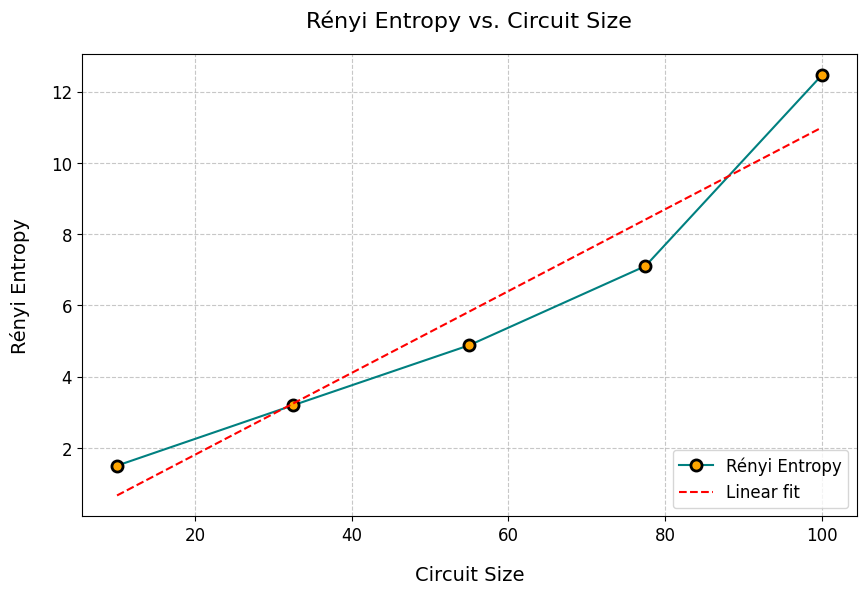

In [30]:


from numpy.polynomial import Polynomial

polyfit = Polynomial.fit(circuit_sizes, renyi_entropies_averaged, deg=1)
y_fit = polyfit(circuit_sizes)

# Create the plot with enhancements
plt.figure(figsize=(10, 6))

# Customize the line style, markers, and color
plt.plot(circuit_sizes, renyi_entropies_averaged, 
         linestyle='-',  # Solid line
         marker='o',     # Circle markers
         color='teal',   # Line color
         markersize=8,   # Marker size
         markerfacecolor='orange',  # Marker fill color
         markeredgewidth=2,         # Marker edge width
         markeredgecolor='black')   # Marker edge color


plt.plot(circuit_sizes,y_fit,color='red',linestyle='--')

# Add titles and labels with custom font sizes and padding
plt.title("Rényi Entropy vs. Circuit Size", fontsize=16, pad=20)
plt.xlabel("Circuit Size", fontsize=14, labelpad=15)
plt.ylabel("Rényi Entropy", fontsize=14, labelpad=15)

# Customize the grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Set the limits for better focus on the data range
# plt.xlim(min(circuit_sizes) - 5, max(circuit_sizes) + 5)
# plt.ylim(min(renyi_entropies) - 0.1, max(renyi_entropies) + 0.1)

# Customize the ticks on the x and y axes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a legend if necessary (example)
plt.legend(["Rényi Entropy","Linear fit"], loc="lower right", fontsize=12)

# Optionally add annotations or a text box
# plt.annotate('Max Entropy', xy=(50, 0.9), xytext=(40, 0.8),
#              arrowprops=dict(facecolor='black', arrowstyle='->'),
#              fontsize=12)

# Show the plot
plt.show()


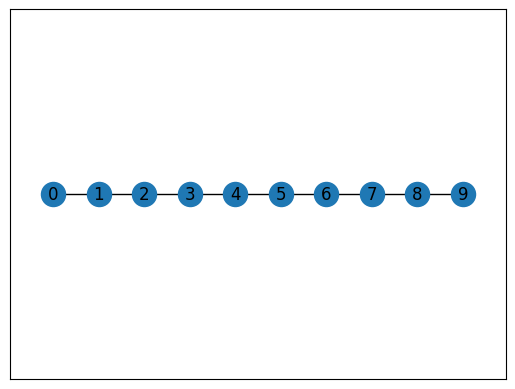

In [24]:
N = 10
G = nx.grid_graph([N])
positions = {}
for i in range(N):
    positions[i] = [i,0]
nx.draw_networkx(G,pos=positions)